# Distro of score metrics for EFO

In [171]:
umls_term_cats = (
    py_.chain(
        [
            [
                [
                    {
                        "term": __["sub_term"],
                        "type": __["sub_type"],
                    },
                    {
                        "term": __["obj_term"],
                        "type": __["obj_type"],
                    },
                ]
                for __ in _["triples"]
            ]
            for _ in triples
            if len(_["triples"]) > 0
        ]
    )
    .flatten_depth(2)
    .thru(lambda items: pd.DataFrame(items))
    .value()
    .drop_duplicates()
)
print(umls_term_cats.info())
print(umls_term_cats[:5])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5945 entries, 0 to 28866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   term    5945 non-null   object
 1   type    5945 non-null   object
dtypes: object(2)
memory usage: 139.3+ KB
None
                              term  type
0                 Behavior Therapy  topp
1       Attention Deficit Disorder  mobd
3              Hemispatial Neglect  mobd
4                       Evaluation  hlca
5  Complex Regional Pain Syndromes  dsyn


In [172]:
def _extract_ents(e):
    subject_ent_ids = [_["ent_id"] for _ in e["subject_ents"]]
    object_ent_ids = [_["ent_id"] for _ in e["object_ents"]]
    subject_ents = [
        {
            "query_term": e["query_subject_term"],
            "efo_id": _["ent_id"],
            "efo_term": _["ent_term"],
            "similarity_score": _["similarity_score"],
            "ic_score": _["ic_score"],
            "identity_score": _["identity_score"],
            "group": ["select", "candidate"]
            if _["ent_id"] in subject_ent_ids
            else ["candidate", "not_select"],
        }
        for _ in e["subject_candidates"]
    ]
    object_ents = [
        {
            "query_term": e["query_object_term"],
            "efo_id": _["ent_id"],
            "efo_term": _["ent_term"],
            "similarity_score": _["similarity_score"],
            "ic_score": _["ic_score"],
            "identity_score": _["identity_score"],
            "group": ["select", "candidate"]
            if _["ent_id"] in object_ent_ids
            else ["candidate", "not_select"],
        }
        for _ in e["object_candidates"]
    ]
    subject_ents_res = subject_ents if len(subject_ent_ids) > 0 else []
    object_ents_res = object_ents if len(object_ent_ids) > 0 else []
    res = subject_ents + object_ents
    return res


ent_mappings = (
    py_.chain([_["efo_ents"] for _ in combined_evidence])
    .map(_extract_ents)
    .flatten()
    .thru(lambda o: pd.DataFrame(o))
    .value()
    .merge(
        umls_term_cats.rename(columns={"term": "query_term"}),
        on=["query_term"],
        how="left",
    )
    .explode("group")
)
print(ent_mappings.info())
ent_mappings

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28402 entries, 0 to 14200
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   query_term        28402 non-null  object 
 1   efo_id            28402 non-null  object 
 2   efo_term          28402 non-null  object 
 3   similarity_score  28402 non-null  float64
 4   ic_score          28402 non-null  float64
 5   identity_score    28402 non-null  float64
 6   group             28402 non-null  object 
 7   type              28402 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.0+ MB
None


,query_term,efo_id,efo_term,similarity_score,ic_score,identity_score,group,type
0,Antihypertensive Agents,http://purl.obolibrary.org/obo/CHEBI_33281,antimicrobial agent,0.726404,0.986427,2.673197,candidate,phsu
0,Antihypertensive Agents,http://purl.obolibrary.org/obo/CHEBI_33281,antimicrobial agent,0.726404,0.986427,2.673197,not_select,phsu
1,Antihypertensive Agents,http://purl.obolibrary.org/obo/CHEBI_35705,immunosuppressive agent,0.814429,0.984331,1.935975,candidate,phsu
1,Antihypertensive Agents,http://purl.obolibrary.org/obo/CHEBI_35705,immunosuppressive agent,0.814429,0.984331,1.935975,not_select,phsu
2,Antihypertensive Agents,http://purl.obolibrary.org/obo/CHEBI_35472,anti-inflammatory drug,0.728815,0.984331,1.334579,select,phsu
...,...,...,...,...,...,...,...,...
14198,"Diabetes Mellitus, Non-Insulin-Dependent",http://www.orpha.net/ORDO/Orphanet_223,Nephrogenic diabetes insipidus,0.769147,0.994190,4.681015,not_select,dsyn
14199,"Diabetes Mellitus, Non-Insulin-Dependent",http://www.orpha.net/ORDO/Orphanet_2596,Myopathy and diabetes mellitus,0.843019,0.998201,3.647223,candidate,dsyn
14199,"Diabetes Mellitus, Non-Insulin-Dependent",http://www.orpha.net/ORDO/Orphanet_2596,Myopathy and diabetes mellitus,0.843019,0.998201,3.647223,not_select,dsyn
14200,"Diabetes Mellitus, Non-Insulin-Dependent",http://www.orpha.net/ORDO/Orphanet_30925,Hereditary central diabetes insipidus,0.705844,0.995674,4.011825,candidate,dsyn


In [173]:
group_counts = (
    ent_mappings[ent_mappings["group"] == "candidate"]
    .groupby(["type"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="group_count")
    .reset_index(drop=False)
)
group_counts

,type,group_count
0,dsyn,7831
1,mobd,1708
2,neop,1516
3,sosy,562
4,phsu,488
5,bacs,314
6,patf,303
7,fndg,266
8,orch,223
9,orgf,190


## main plot

                                       efo_id entity_group term_type  \
0  http://purl.obolibrary.org/obo/CHEBI_33281    candidate       all   
1  http://purl.obolibrary.org/obo/CHEBI_33281   not_select       all   
2  http://purl.obolibrary.org/obo/CHEBI_35705    candidate       all   
3  http://purl.obolibrary.org/obo/CHEBI_35705   not_select       all   
4  http://purl.obolibrary.org/obo/CHEBI_35472       select       all   

   score_type     score  
0  similarity  0.726404  
1  similarity  0.726404  
2  similarity  0.814429  
3  similarity  0.814429  
4  similarity  0.728815  


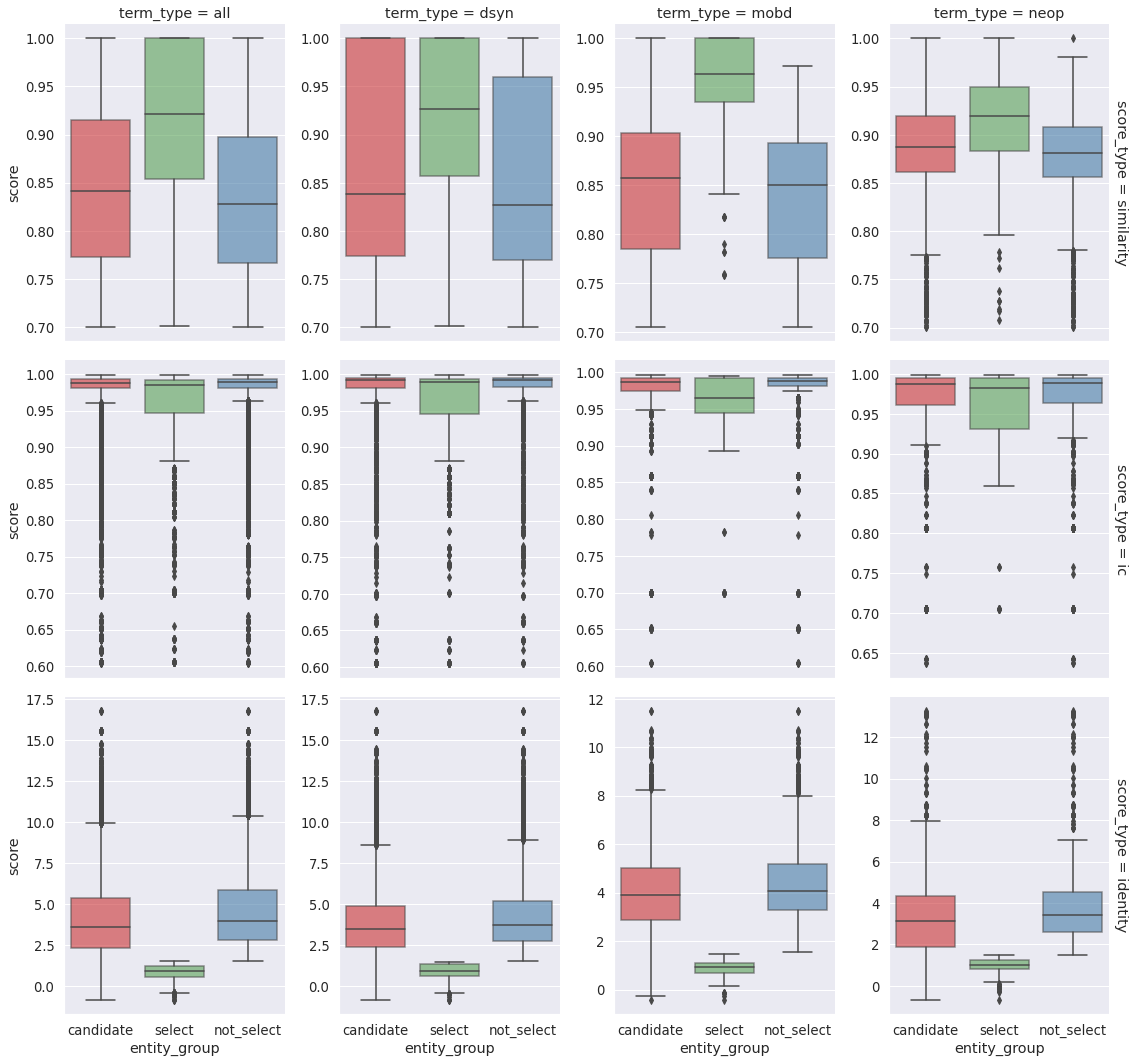

In [179]:
plot_data = (
    pd.concat(
        [
            ent_mappings.assign(type="all"),
            ent_mappings[ent_mappings["type"].isin(group_counts["type"][:3])],
        ]
    )
    .rename(
        columns={
            "type": "term_type",
            "group": "entity_group",
            "similarity_score": "similarity",
            "ic_score": "ic",
            "identity_score": "identity",
        }
    )
    .pipe(
        lambda df: pd.melt(
            df,
            value_vars=["similarity", "ic", "identity"],
            id_vars=["efo_id", "entity_group", "term_type"],
            var_name="score_type",
            value_name="score",
        )
    )
)
print(plot_data[:5])
sns.set(font_scale=1.2)
plot = sns.catplot(
    data=plot_data,
    hue="entity_group",
    y="score",
    x="entity_group",
    order=["candidate", "select", "not_select"],
    col_order=["all", "dsyn", "mobd", "neop"],
    row_order=["similarity", "ic", "identity"],
    margin_titles=True,
    col="term_type",
    row="score_type",
    kind="box",
    # col_wrap=3,
    aspect=0.8,
    palette="Set1",
    boxprops={"alpha": 0.6},
    sharey=False,
    dodge=False,
    width=0.8,
)

In [180]:
plot.fig.savefig(analysis_assets_dir / "distro-ent-harmonization.pdf")

## sub plot

In [181]:
data = ent_mappings.rename(
    columns={
        "type": "term_type",
        "group": "entity_group",
        "similarity_score": "similarity",
        "ic_score": "ic",
        "identity_score": "identity",
    }
).pipe(
    lambda df: pd.melt(
        df,
        value_vars=["similarity", "ic", "identity"],
        id_vars=["efo_id", "entity_group", "term_type"],
        var_name="score_type",
        value_name="score",
    )
)
print(data[:5])
output_file = analysis_assets_dir / "distro-ent-harmonization.csv"
data.groupby(["entity_group", "term_type", "score_type"]).describe().reset_index(
    drop=False
).to_csv(output_file, index=False)

                                       efo_id entity_group term_type  \
0  http://purl.obolibrary.org/obo/CHEBI_33281    candidate      phsu   
1  http://purl.obolibrary.org/obo/CHEBI_33281   not_select      phsu   
2  http://purl.obolibrary.org/obo/CHEBI_35705    candidate      phsu   
3  http://purl.obolibrary.org/obo/CHEBI_35705   not_select      phsu   
4  http://purl.obolibrary.org/obo/CHEBI_35472       select      phsu   

   score_type     score  
0  similarity  0.726404  
1  similarity  0.726404  
2  similarity  0.814429  
3  similarity  0.814429  
4  similarity  0.728815  


## entity category count

In [182]:
umls_cat_count = (
    umls_term_cats.groupby("type")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="umls_count")
    .reset_index(drop=False)
)
umls_cat_count

,type,umls_count
0,dsyn,888
1,fndg,509
2,topp,509
3,gngm,504
4,aapp,487
...,...,...
74,fish,1
75,emst,1
76,eehu,1
77,emod,1


In [183]:
combined_cat_count = group_counts.rename(columns={"group_count": "efo_count"}).merge(
    umls_cat_count, on=["type"]
)
combined_cat_count.to_csv(
    analysis_assets_dir / "entity-count-by-category.csv", index=False
)
combined_cat_count

,type,efo_count,umls_count
0,dsyn,7831,888
1,mobd,1708,125
2,neop,1516,138
3,sosy,562,124
4,phsu,488,447
5,bacs,314,98
6,patf,303,171
7,fndg,266,509
8,orch,223,253
9,orgf,190,74


# Distro  of score metrics for UMLS and traits

In [184]:
def _extract_ents(e):
    def _extract(_, ent_group, query_term):
        return {
            "query_term": query_term,
            "ent_id": _["ent_id"],
            "ent_term": _["ent_term"],
            "ref_meta_ent": _["ref_meta_ent"],
            "similarity_score": _["similarity_score"],
            "ent_group": ent_group,
        }

    ents = (
        py_.chain(
            [
                {
                    "ents": e["umls_ents"]["subject_ents"],
                    "query_term": e["query_subject_term"],
                    "ent_group": "UMLS",
                },
                {
                    "ents": e["umls_ents"]["object_ents"],
                    "query_term": e["query_object_term"],
                    "ent_group": "UMLS",
                },
                {
                    "ents": e["trait_ents"]["subject_ents"],
                    "query_term": e["query_subject_term"],
                    "ent_group": "trait",
                },
                {
                    "ents": e["trait_ents"]["object_ents"],
                    "query_term": e["query_object_term"],
                    "ent_group": "trait",
                },
            ]
        )
        .map(
            lambda items: (
                py_.chain(items["ents"])
                .map(
                    lambda _: _extract(
                        _, query_term=items["query_term"], ent_group=items["ent_group"]
                    )
                )
                .value()
            )
        )
        .reduce(lambda a, b: a + b)
        .value()
    )
    return ents


umls_trait_ent_mappings = (
    py_.chain(
        [
            {
                "umls_ents": _["umls_ents"],
                "trait_ents": _["trait_ents"],
                "query_subject_term": _["efo_ents"]["query_subject_term"],
                "query_object_term": _["efo_ents"]["query_object_term"],
            }
            for _ in combined_evidence
        ]
    )
    .map(_extract_ents)
    .flatten()
    .thru(lambda o: pd.DataFrame(o))
    .value()
    .merge(
        umls_term_cats.rename(columns={"term": "query_term"}),
        on=["query_term"],
        how="left",
    )
)
print(umls_trait_ent_mappings.info())
umls_trait_ent_mappings

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60430 entries, 0 to 60429
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   query_term        60430 non-null  object 
 1   ent_id            60430 non-null  object 
 2   ent_term          60430 non-null  object 
 3   ref_meta_ent      60430 non-null  object 
 4   similarity_score  60430 non-null  float64
 5   ent_group         60430 non-null  object 
 6   type              60430 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.7+ MB
None


,query_term,ent_id,ent_term,ref_meta_ent,similarity_score,ent_group,type
0,Antihypertensive Agents,C0003364,Antihypertensive Agents,QueryUMLS,1.000000,UMLS,phsu
1,Antihypertensive Agents,C1516000,Antilipidemic Agent,QueryUMLS,0.876444,UMLS,phsu
2,Antihypertensive Agents,C0003367,Antilipemic Agents,QueryUMLS,0.875107,UMLS,phsu
3,Antihypertensive Agents,C0003405,Antiparkinson Agents,QueryUMLS,0.864816,UMLS,phsu
4,Antihypertensive Agents,C0085826,Antiplatelet Agents,QueryUMLS,0.863656,UMLS,phsu
...,...,...,...,...,...,...,...
60425,"Diabetes Mellitus, Non-Insulin-Dependent",ieu-a-25,Type 2 diabetes,Efo,0.784188,trait,dsyn
60426,"Diabetes Mellitus, Non-Insulin-Dependent",ieu-a-1090,Type 2 diabetes,Efo,0.784188,trait,dsyn
60427,"Diabetes Mellitus, Non-Insulin-Dependent",ieu-a-24,Type 2 diabetes,Efo,0.784188,trait,dsyn
60428,"Diabetes Mellitus, Non-Insulin-Dependent",ieu-a-26,Type 2 diabetes,Efo,0.784188,trait,dsyn


   index               query_term    ent_id                 ent_term  \
0      0  Antihypertensive Agents  C0003364  Antihypertensive Agents   
1      1  Antihypertensive Agents  C1516000      Antilipidemic Agent   
2      2  Antihypertensive Agents  C0003367       Antilipemic Agents   
3      3  Antihypertensive Agents  C0003405     Antiparkinson Agents   
4      4  Antihypertensive Agents  C0085826      Antiplatelet Agents   

  ref_meta_ent  similarity_score entity_group term_type  
0    QueryUMLS          1.000000         UMLS       all  
1    QueryUMLS          0.876444         UMLS       all  
2    QueryUMLS          0.875107         UMLS       all  
3    QueryUMLS          0.864816         UMLS       all  
4    QueryUMLS          0.863656         UMLS       all  


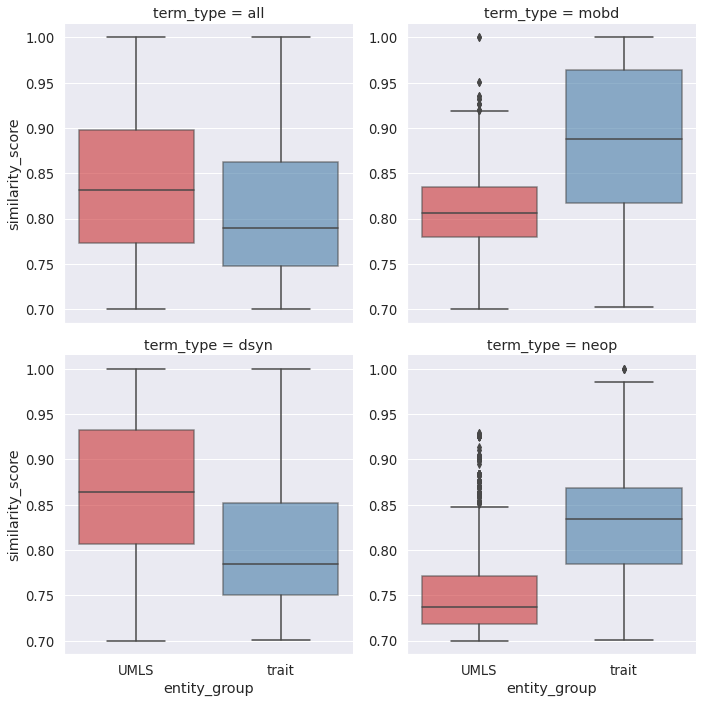

In [185]:
plot_data = (
    pd.concat(
        [
            umls_trait_ent_mappings.assign(type="all"),
            umls_trait_ent_mappings[
                umls_trait_ent_mappings["type"].isin(group_counts["type"][:3])
            ],
        ]
    )
    .rename(
        columns={
            "type": "term_type",
            "ent_group": "entity_group",
        }
    )
    .reset_index(drop=False)
)
print(plot_data[:5])
sns.set(font_scale=1.2)
plot = sns.catplot(
    data=plot_data,
    hue="entity_group",
    y="similarity_score",
    x="entity_group",
    # order=["candidate", "select", "not_select"],
    # col_order=["all", "dsyn", "mobd", "neop"],
    # row_order=["similarity", "ic", "identity"],
    col="term_type",
    # row="score_type",
    margin_titles=True,
    kind="box",
    col_wrap=2,
    boxprops={"alpha": 0.6},
    palette="Set1",
    sharey=False,
    dodge=False,
    width=0.8,
)

In [186]:
plot.fig.savefig(analysis_assets_dir / "distro-ent-harmonization-umls-traits.pdf")